In [11]:
#imports
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
import gsw
import netCDF4
import dbdreader

import correctSensorLag_Slater as csLag
import correctThermalLag_Slater as ctLag
import findThermalLagParams_TS_Slater as ftlpTS
import findThermalLagParams_SP_Slater as ftlpSP

In [12]:
#ignores divide by 0 errors in later step
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [13]:
#extract data and rename variables

data_files = '/Users/jack/Documents/gliderData/sylvia-20180802/all_data/*.[D|E]BD'
cac_dir = '/Users/jack/Documents/gliderData/sylvia-20180802/cache'

sensors = ['sci_ctd41cp_timestamp','sci_water_pressure','sci_water_temp','sci_water_cond','m_lat','m_lon','m_tot_num_inflections']

dbd = dbdreader.MultiDBD(pattern=data_files,cacheDir=cac_dir) 

tm,sensor_title=dbd.get(sensors[0])
sensor0_time_pair = np.column_stack((tm, sensor_title))
sensor0_time_pair[:,0] = pd.to_datetime(sensor0_time_pair[:,0], unit='s')
glider_sci = pd.DataFrame(sensor0_time_pair,columns=['time',sensors[0]])
glider_sci['time'] = pd.to_datetime(glider_sci['time'])

for sensor_titles in sensors[1:]:
    dbd=dbdreader.MultiDBD(pattern=data_files,cacheDir=cac_dir)    
    tm,sensor_data=dbd.get(sensor_titles)
    sensor_time_pair = np.column_stack((tm, sensor_data))
    sensor_time_pair[:,0] = pd.to_datetime(sensor_time_pair[:,0], unit='s')
    sensor_time_df = pd.DataFrame(sensor_time_pair,columns=['time',sensor_titles])
    sensor_time_df['time'] = pd.to_datetime(sensor_time_df['time'])
    glider_sci = glider_sci.merge(sensor_time_df, on='time', how='outer').sort_values(by='time')

#drop all rows without ctd timestamp and duplicate ctd timestamps and rename columns and data frame to sci_data
sci_data = glider_sci.rename(columns={"sci_ctd41cp_timestamp": "ctd_time", "sci_water_pressure": "pressure", "sci_water_temp": "temperature", \
    "sci_water_cond": "conductivity","m_lat":"latitude","m_lon":"longitude"})

#assign profiles ids based on m_tot_num_inflections
sci_data['m_tot_num_inflections'].ffill(inplace=True)
sci_data['m_tot_num_inflections'].bfill(inplace=True)

sci_data['latitude'] = sci_data['latitude'].interpolate()
sci_data['longitude'] = sci_data['longitude'].interpolate()
sci_data = sci_data[sci_data['ctd_time'].ne(0)].dropna(subset=['ctd_time'])
sci_data = sci_data.drop_duplicates(subset=['ctd_time'])
sci_data = sci_data[sci_data['latitude'].ne(0)].dropna(subset=['latitude'])
sci_data = sci_data[sci_data['longitude'].ne(0)].dropna(subset=['longitude'])
sci_data['profile_id'] = sci_data.groupby('m_tot_num_inflections').ngroup()
sci_data.reset_index(drop=True,inplace=True) #reset indices

sci_data['pressure'] = sci_data['pressure'].mul(10)
sci_data['z'] = gsw.z_from_p(sci_data['pressure'].values,sci_data['latitude'].values)
sci_data['conductivity_ms_cm'] = sci_data['conductivity'].mul(10)
sci_data['salinity'] = gsw.SP_from_C(sci_data['conductivity_ms_cm'].values,sci_data['temperature'].values,sci_data['pressure'].values)

profile_groups = sci_data.groupby("profile_id")

def drop_top_and_bottom(group):

    group.drop(group[group['z'] > -2].index, inplace=True)
    group.drop(group[group['z'] < (group['z'].min()+2)].index, inplace=True)
    return group

sci_data = profile_groups.apply(drop_top_and_bottom)
sci_data.reset_index(drop=True,inplace=True) #reset indices

In [14]:
profile_groups = sci_data.groupby("profile_id")
profile_stats = pd.DataFrame() #create dataframe for profile statistics

def set_profile_time(group):
    profile_id = group.iloc[0]['profile_id']
    n_points = group['ctd_time'].size
    profile_time = group.iloc[n_points//2]['ctd_time']
    profile_stats.loc[profile_id,'profile_time'] = profile_time

profile_groups.apply(set_profile_time)

""


In [15]:
## correction for ctd sensor response time (lag from measurement to recording).
# this is not used in practice, because pressure sensor lag is assumed to be 0.

# P_sensor_lag = 0 means no correction.
P_sensor_lag = 0 # 0, assuming pressure is recorded correctly and instantly as the CTD time stamp
T_sensor_lag = 0 

sci_data['pressure_lag_shifted'] = csLag.correctSensorLag(sci_data['ctd_time'], sci_data['pressure'], P_sensor_lag)

sci_data['z_lag_shifted'] = csLag.correctSensorLag(sci_data['ctd_time'], sci_data['z'], P_sensor_lag)

sci_data['temperature_lag_shifted'] = csLag.correctSensorLag(sci_data['ctd_time'], sci_data['temperature'], T_sensor_lag)

#smoothing

mov_window = 5
sci_data['pressure_lag_shifted_smooth'] = sci_data['pressure_lag_shifted'].rolling(mov_window, min_periods=1, center=True).mean()

sci_data['z_lag_shifted_smooth'] = sci_data['z_lag_shifted'].rolling(mov_window, min_periods=1, center=True).mean()

#conductivity

Vol = 1.5; # based on diagram from Kim Martini of Sea-Bird.
Q = 10; # flow rate in ml/s.

TC_sensor_lag = Vol/Q

sci_data['conductivity_lag_shifted'] = csLag.correctSensorLag(sci_data['ctd_time'], sci_data['conductivity'], TC_sensor_lag)

sci_data['conductivity_lag_shifted_smooth'] = sci_data['conductivity_lag_shifted'].rolling(mov_window, min_periods=1, center=True).mean()

# Thermister reponse correction for temperature data
# This step is neccesary. assuming tau_T = 0.53 sec. 

# according to Kim Martini's slides:
# "Response time for this temperature sensor construction can range from 0.1-0.6 seconds.
# This can vary depending on the pump and profiling speed of the platform."

# smooth raw temperature data. 3 measurement points corresponds to about 6 seconds.
# this avoids extremely large dT/dt, dT/dz

sci_data['temperature_lag_shifted_smooth'] = sci_data['temperature_lag_shifted'].rolling(mov_window, min_periods=1, center=True).mean()

dt = sci_data['ctd_time'].diff()

dt = dt[1:,]

tlsm = sci_data['temperature_lag_shifted_smooth'].diff()

dT_dt_smooth = np.divide(tlsm[1:,],dt)

tau_T = 0.53; # in seconds. nominal value is 0.5 second based on Johnson et al. 2007

sci_data['temperature_response_corrected_smooth'] = sci_data['temperature_lag_shifted_smooth']

sci_data.loc[1:,'temperature_response_corrected_smooth'] = sci_data.loc[1:,'temperature_lag_shifted_smooth'].add(np.multiply(tau_T,dT_dt_smooth))

In [16]:
#Step 2 Prepare Profile Data 

n_profiles = sci_data['profile_id'].nunique()

#profile = sci_data.set_index('profile_id', append = True, drop = False).reorder_levels(order = [1,0]).sort_index()

# find profile direction (up or down), find real profiles (pressure range > 2 dbar)

profile_pressure_range_cutoff = 5; # dbar
temperature_diff_cutoff = 4; # C

profile_stats['n_profile_values'] = sci_data.groupby('profile_id')['ctd_time'].agg('count')
profile_stats['pressure_diff'] = sci_data.groupby('profile_id')['pressure'].agg('last') - sci_data.groupby('profile_id')['pressure'].agg('first')
profile_stats['temperature_diff'] = sci_data.groupby('profile_id')['temperature'].agg('max') - sci_data.groupby('profile_id')['temperature'].agg('min')

profile_stats['profile_direction'] = np.select([profile_stats['pressure_diff'] >= profile_pressure_range_cutoff, \
    profile_stats['pressure_diff'] <= -profile_pressure_range_cutoff],[1,-1],0) #1 is downcast, -1 is upcast, 0 is null

profile_stats['stratification_flag'] = np.select([profile_stats['temperature_diff'] >= temperature_diff_cutoff],[1],0)

In [17]:
profile_groups = sci_data.groupby("profile_id")

def find_interface_thickness_percentiles(group):
    profile_id = group.iloc[0]['profile_id']

    if profile_stats.loc[profile_id,'stratification_flag'] == 1:

        temp = group['temperature']
        pressure = group['pressure']
        temp = temp.sort_values(ascending=True)
        p85 = temp.quantile(0.85)
        p15 = temp.quantile(0.15)
        idx85 = temp.iloc[:temp.searchsorted(p85)].idxmax()
        idx15 = temp.iloc[temp.searchsorted(p15):].idxmin()
        pres_bound1 = pressure[idx15]
        pres_bound2 = pressure[idx85]
        interface_thickness = np.abs(pres_bound1-pres_bound2)
        profile_stats.loc[profile_id,'interface_thickness'] = interface_thickness

    else:
        interface_thickness = np.nan
        profile_stats.loc[profile_id,'interface_thickness'] = interface_thickness

def find_interface_thickness_Daniel(group):
    profile_id = group.iloc[0]['profile_id']

    if profile_stats.loc[profile_id,'stratification_flag'] == 1:
        
        temp = group['temperature']
        pressure = group['pressure']
        tempdiff = profile_stats.loc[profile_id,'temperature_diff']
        mintemp = temp.min() + 0.15*tempdiff
        maxtemp = temp.max() - 0.15*tempdiff
        indices = temp[(temp >= mintemp) & (temp <= maxtemp)].index
        interface_measurements_count = len(indices)
        profile_stats.loc[profile_id,'interface_measurements_count'] = interface_measurements_count
        max_pressure = pressure[indices].max()
        min_pressure = pressure[indices].min()
        interface_thickness = np.abs(max_pressure-min_pressure)
        if np.isnan(interface_thickness):
            interface_thickness = 0.1
        profile_stats.loc[profile_id,'interface_thickness'] = interface_thickness

    else:
        interface_thickness = np.nan
        profile_stats.loc[profile_id,'interface_thickness'] = interface_thickness

result = profile_groups.apply(find_interface_thickness_Daniel)

In [18]:
profile_groups = sci_data.groupby("profile_id")
def find_gradient_per_profile(group):
    gradient1 = np.gradient(group['temperature_response_corrected_smooth'], group['z_lag_shifted_smooth'])
    group['dT_dz_smooth'] = gradient1
    gradient2 = np.gradient(group['dT_dz_smooth'], group['z_lag_shifted_smooth'])
    group['d2T_dz2_smooth'] = gradient2
    return group

sci_data = profile_groups.apply(find_gradient_per_profile)

In [19]:
profile_groups = sci_data.groupby("profile_id")

def find_thermocline_z_p(group):
    profile_id = group.iloc[0]['profile_id']
    ind_zrange = (group['z'] < -4) & (group['z'] > (2+group['z'].min()))
    if group['z'][ind_zrange].empty:
        profile_stats.loc[profile_id,'thermocline_z'] = np.nan
        profile_stats.loc[profile_id,'thermocline_pressure'] = np.nan
    else:
        ind1 = group['dT_dz_smooth'].abs() == group['dT_dz_smooth'][ind_zrange].abs().max()
        profile_stats.loc[profile_id,'thermocline_z'] = group['z_lag_shifted_smooth'][ind1].mean()
        profile_stats.loc[profile_id,'thermocline_pressure'] = group['pressure_lag_shifted_smooth'][ind1].mean()

result = profile_groups.apply(find_thermocline_z_p)

In [20]:
for iter in range(n_profiles):
    idx = (sci_data['profile_id'] == iter)
    profile_stats.loc[iter,'thermal_lag_flag'] = 0

    cond3 = sci_data[idx]['pressure'].max() >= 10
    cond4 = np.abs(profile_stats.loc[iter,'pressure_diff']) >= 10
    cond5 = np.abs(profile_stats.loc[iter,'temperature_diff']) >= 1

    if iter == 0:
        cond1 = profile_stats.loc[iter,'profile_direction']*profile_stats.loc[(iter+1),'profile_direction'] == -1
        profile_stats.loc[iter,'thermal_lag_flag'] = np.select([cond1 & cond3 & cond4 & cond5],[1],0)

    elif iter<(n_profiles-1):
        cond1 = profile_stats.loc[iter,'profile_direction']*profile_stats.loc[(iter+1),'profile_direction'] == -1
        cond2 = profile_stats.loc[iter,'profile_direction']*profile_stats.loc[(iter-1),'profile_direction'] == -1
        profile_stats.loc[iter,'thermal_lag_flag'] = np.select([(cond1 or cond2) & cond3 & cond4 & cond5],[1],0)

    elif iter == (n_profiles-1):
        cond2 = profile_stats.loc[iter,'profile_direction']*profile_stats.loc[(iter-1),'profile_direction'] == -1
        profile_stats.loc[iter,'thermal_lag_flag'] = np.select([cond2 & cond3 & cond4 & cond5],[1],0)

In [21]:
for iter in range(n_profiles):
    idx = (sci_data['profile_id'] == iter)
    current = profile_stats.loc[iter, 'thermal_lag_flag']
    cond6 = profile_stats.loc[iter, 'interface_thickness'] < 8
    cond7 = ~np.isnan(profile_stats.loc[iter, 'interface_thickness'])
    cond8 = profile_stats.loc[iter, 'interface_measurements_count'] <= 32
    cond9 = sci_data[idx]['pressure'].max() - profile_stats.loc[iter,'thermocline_pressure'] >= 2
    cond10 = profile_stats.loc[iter,'thermocline_pressure'] - sci_data[idx]['pressure'].min() >= 2
    cond11 = profile_stats.loc[iter, 'thermal_lag_flag'] == 1

    profile_stats.loc[iter,'thermal_lag_flag'] = np.select([cond6 & cond7 & cond8 & cond9 & cond10 & cond11],[2],current)

In [22]:
#Step 3
profile_groups = sci_data.groupby("profile_id")

def run_thermal_lag_params(group):
    profile_id = group.iloc[0]['profile_id']
    try:
        if profile_id == 0:
            pair_group = profile_groups.get_group(profile_id + 1)
        elif profile_id == n_profiles-1:
            pair_group = profile_groups.get_group(profile_id - 1)
        else:
            below = np.abs(profile_stats.loc[profile_id,'profile_time'] - profile_stats.loc[profile_id-1,'profile_time'])
            above = np.abs(profile_stats.loc[profile_id,'profile_time'] - profile_stats.loc[profile_id+1,'profile_time'])
            if (below < above):
                pair_group = profile_groups.get_group(profile_id - 1)
            else:
                pair_group = profile_groups.get_group(profile_id + 1)

        profile_id2 = pair_group.iloc[0]['profile_id']

        time1 = np.array(group['ctd_time'])
        temp1 = np.array(group['temperature'])
        cond1 = np.array(group['conductivity'])
        pres1 = np.array(group['pressure'])
        thermocline_pres1 = profile_stats.loc[profile_id,'thermocline_pressure']
        time2 = np.array(pair_group['ctd_time'])
        temp2 = np.array(pair_group['temperature'])
        cond2 = np.array(pair_group['conductivity'])
        pres2 = np.array(pair_group['pressure'])
        thermocline_pres2 = profile_stats.loc[profile_id2,'thermocline_pressure']
        lat1 = np.array(group['latitude'])
        lon1 = np.array(group['longitude'])
        lat2 = np.array(pair_group['latitude'])
        lon2 = np.array(pair_group['longitude'])


        if profile_stats.loc[iter,'thermal_lag_flag'] == 1:
            params = ftlpTS.findThermalLagParams_TS(time1, cond1, temp1, pres1, time2, cond2, temp2, pres2)

        elif profile_stats.loc[iter,'thermal_lag_flag'] == 2:
            params = ftlpSP.findThermalLagParams_SP(time1, cond1, temp1, pres1, thermocline_pres1, time2, cond2, temp2, pres2, thermocline_pres2)

        [temp_inside1,cond_outside1] = ctLag.correctThermalLag(time1,cond1,temp1,params.x)
        [temp_inside2,cond_outside2] = ctLag.correctThermalLag(time2,cond2,temp2,params.x)

        salt_cor1 = gsw.SP_from_C(np.multiply(cond_outside1,10),temp1,pres1)

        saltA_outside1 = gsw.SA_from_SP(salt_cor1,pres1,lon1,lat1)

        ctemp_outside1 = gsw.CT_from_t(saltA_outside1, temp1, pres1)

        ptemp_outside1 = gsw.pt_from_CT(saltA_outside1, ctemp_outside1)

        rho_outside1 = gsw.rho(saltA_outside1,ctemp_outside1,pres1)

        sigma0_outside1 = gsw.sigma0(saltA_outside1,ctemp_outside1)
        
        profile_stats.loc[profile_id,'alpha'] = params.x[0]
        profile_stats.loc[profile_id,'tau'] = params.x[1]

        group['salt_outside'] = salt_cor1
        group['saltA_outside'] = saltA_outside1
        group['ctemp_outside'] = ctemp_outside1
        group['ptemp_outside'] = ptemp_outside1
        group['rho_outside'] = rho_outside1
        group['sigma0_outside'] = sigma0_outside1

        print(f'{profile_id} worked')
    except Exception as e:
        print(f'{profile_id} did not work')
        print(e)
    return group

sci_data_cor = profile_groups.apply(run_thermal_lag_params)

0 worked
1 worked
2 worked
3 did not work
index 0 is out of bounds for axis 0 with size 0
4 did not work
index 0 is out of bounds for axis 0 with size 0
5 worked
6 worked
7 worked
8 worked
9 worked
10 worked
11 worked
12 worked
13 worked
14 worked
15 worked
16 worked
17 worked
18 worked
19 worked
20 worked
21 worked
22 worked
23 worked
24 worked
25 worked
26 worked
27 worked
28 worked
29 worked
30 worked
31 worked
32 worked
33 worked
34 worked
35 worked
36 worked
37 worked
38 worked
39 worked
40 worked
41 worked
42 worked
43 worked
44 worked
45 worked
46 worked
47 worked
48 worked
49 worked
50 worked
51 worked
52 worked
53 did not work
index 0 is out of bounds for axis 0 with size 0
54 did not work
index 0 is out of bounds for axis 0 with size 0
55 worked
56 worked
57 worked
58 worked
59 did not work
index 0 is out of bounds for axis 0 with size 0
60 did not work
index 0 is out of bounds for axis 0 with size 0
61 worked
62 worked
63 worked
64 worked
65 worked
66 worked
67 worked
68 wor

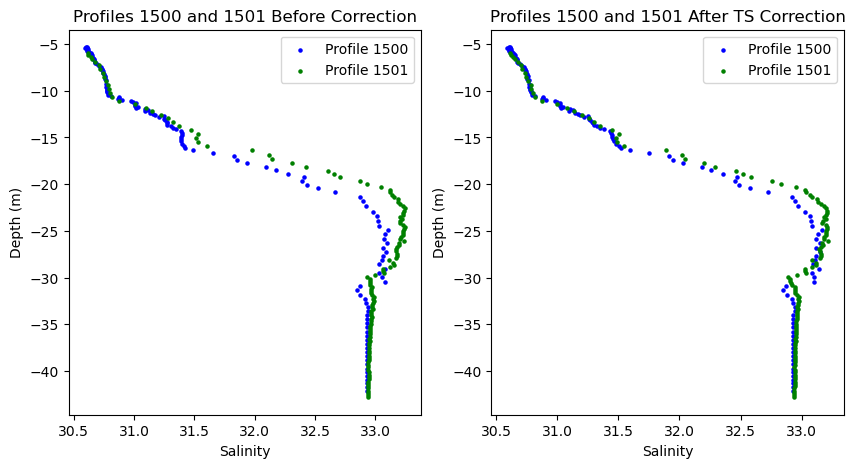

In [23]:
profile_groups_cor = sci_data_cor.groupby('profile_id')
profile_groups = sci_data.groupby('profile_id')

def before_and_after_TS(profile_groups, profile_groups_cor, profile):

    if profile == 0:
        comp = 1
    elif profile == n_profiles-1:
        comp=-1
    else:
        below = np.abs(profile_stats.loc[profile,'profile_time'] - profile_stats.loc[profile-1,'profile_time'])
        above = np.abs(profile_stats.loc[profile,'profile_time'] - profile_stats.loc[profile+1,'profile_time'])
        if (below < above):
            comp = -1
        else:
            comp = 1

    group = profile_groups.get_group(profile)
    group_cor = profile_groups_cor.get_group(profile)

    next_group = profile_groups.get_group(profile+comp)
    next_group_cor = profile_groups_cor.get_group(profile+comp)

    if profile_stats.loc[profile,'thermal_lag_flag'] == 1:
        cor_type = 'TS'
    elif profile_stats.loc[profile,'thermal_lag_flag'] == 2:
        cor_type = 'SP'
    else:
        cor_type = 'NO'

    temp = group['temperature']
    temp_cor = group_cor['temperature']

    salinity = group['salinity']
    salinity_cor = group_cor['salt_outside']

    depth = group['z']

    next_temp = next_group['temperature']
    next_temp_cor = next_group_cor['temperature']

    next_salinity = next_group['salinity']
    next_salinity_cor = next_group_cor['salt_outside']

    next_depth = next_group['z']

    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(121)
    ax1.scatter(salinity, depth, 5, 'b', label=f'Profile {profile}')
    ax1.scatter(next_salinity, next_depth, 5, 'g', label=f'Profile {profile+comp}')
    ax1.set_title(f'Profiles {profile} and {profile+1} Before Correction')
    ax1.legend()
    ax1.set_xlabel('Salinity')
    ax1.set_ylabel('Depth (m)')

    ax2 = fig.add_subplot(122)
    ax2.scatter(salinity_cor, depth, 5, 'b', label=f'Profile {profile}')
    ax2.scatter(next_salinity_cor, next_depth, 5, 'g', label=f'Profile {profile+comp}')
    ax2.set_title(f'Profiles {profile} and {profile+1} After {cor_type} Correction')
    ax2.legend()
    ax2.set_xlabel('Salinity')
    ax2.set_ylabel('Depth (m)')

    plt.show()

before_and_after_TS(profile_groups,profile_groups_cor, 1500)